<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Neural_Net_centralized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [2]:
!pip install --quiet fastai==2.2.5

     |████████████████████████████████| 194kB 6.6MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 12.8MB 229kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [3]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf

# Preprocessing

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
data = pd.get_dummies(data)
cols = mf.get_col(data)

In [5]:
load = False
save_id = True 

if load:
  X_test, y_test = mf.get_set('test_id', data, 'xgboost_numpy', labels = True)
if not load:
  X_train, X_test, y_train, y_test = mf.split(data, test_size = 0.2)
  # X_train, y_train = overSampling(X_train, y_train)
  del data
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
if save_id:
  train_id = X_train.index.tolist()
  val_id = X_val.index.tolist()
  test_id = X_test.index.tolist()
  mf.save_list('train_id',train_id)
  mf.save_list('val_id', val_id)
  mf.save_list('test_id', test_id)

# Neural Network

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, BatchNormalization

keras.backend.clear_session()

model = Sequential()
model.add(Input(shape=(X_train.shape[1],))) 
model.add(Dense(360, activation=tf.keras.activations.gelu)) 
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=512, # 1000
    validation_data=(X_val,y_val),
    verbose=1,
    shuffle = True , 
    class_weight = {0: 1, 1: 3.5}
)

Epoch 1/40
693/693 [==============================] - 11s 11ms/step - loss: 0.3846 - accuracy: 0.9072 - recall: 0.3641 - precision: 0.1960 - val_loss: 0.2178 - val_accuracy: 0.9086 - val_recall: 0.4830 - val_precision: 0.1882
Epoch 2/40
693/693 [==============================] - 7s 9ms/step - loss: 0.2675 - accuracy: 0.9591 - recall: 0.3512 - precision: 0.4044 - val_loss: 0.1598 - val_accuracy: 0.9449 - val_recall: 0.4401 - val_precision: 0.3042
Epoch 3/40
693/693 [==============================] - 6s 9ms/step - loss: 0.2514 - accuracy: 0.9624 - recall: 0.3749 - precision: 0.4490 - val_loss: 0.1462 - val_accuracy: 0.9608 - val_recall: 0.3483 - val_precision: 0.4296
Epoch 4/40
693/693 [==============================] - 6s 9ms/step - loss: 0.2450 - accuracy: 0.9638 - recall: 0.3917 - precision: 0.4637 - val_loss: 0.1155 - val_accuracy: 0.9665 - val_recall: 0.3228 - val_precision: 0.5379
Epoch 5/40
693/693 [==============================] - 7s 10ms/step - loss: 0.2466 - accuracy: 0.9617 -

# Performance evaluation

In [12]:
# test_loss, test_acc = model.evaluate(X_test, y_test)

# print()
# print('Test Loss:\t', test_loss)
# print('Test Accuracy:\t', test_acc)

In [13]:
y_pred = model.predict(X_test)

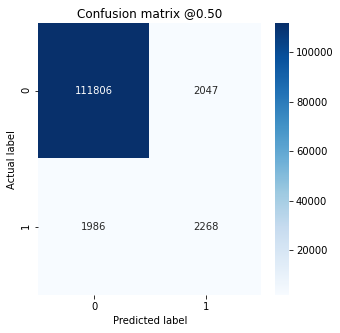

In [15]:
mf.plot_cm(y_test, y_pred,  'Blues')

AUC:  0.8966453955376461


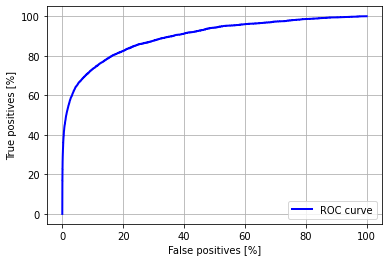

In [16]:
mf.plot_roc("ROC curve", y_test, y_pred,color='blue')

Average precision:  0.5554506866421277


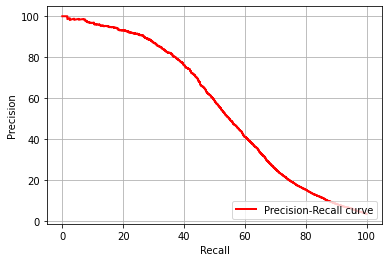

In [17]:
mf.plot_ap('Precision-Recall curve', y_test, y_pred, color = 'red')

In [18]:
y_predicted = []
for prob in y_pred:
  if prob >= 0.5:
    y_predicted.append(1)
  else:
    y_predicted.append(0)

In [19]:
from sklearn.metrics import f1_score, recall_score, precision_score
print('F1 score: ',f1_score(y_test, y_predicted, average="binary"))
print('Recall: ', recall_score(y_test, y_predicted, average='binary'))
print('Precision: ', precision_score(y_test, y_predicted,  average='binary'))

F1 score:  0.5293499824950403
Recall:  0.5331452750352609
Precision:  0.5256083429895713


In [21]:
save = True
if save:
  model.save('centralized_mlp')

INFO:tensorflow:Assets written to: centralized_mlp/assets
